In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/rsfmeasureddata2011.csv")

df['Date and Time'] = pd.to_datetime(df['Date and Time'])
df.set_index('Date and Time', inplace=True)

df = df.drop(columns=['Unnamed: 11'])


In [3]:
df_clean = df.drop(columns=['Day of Week'])

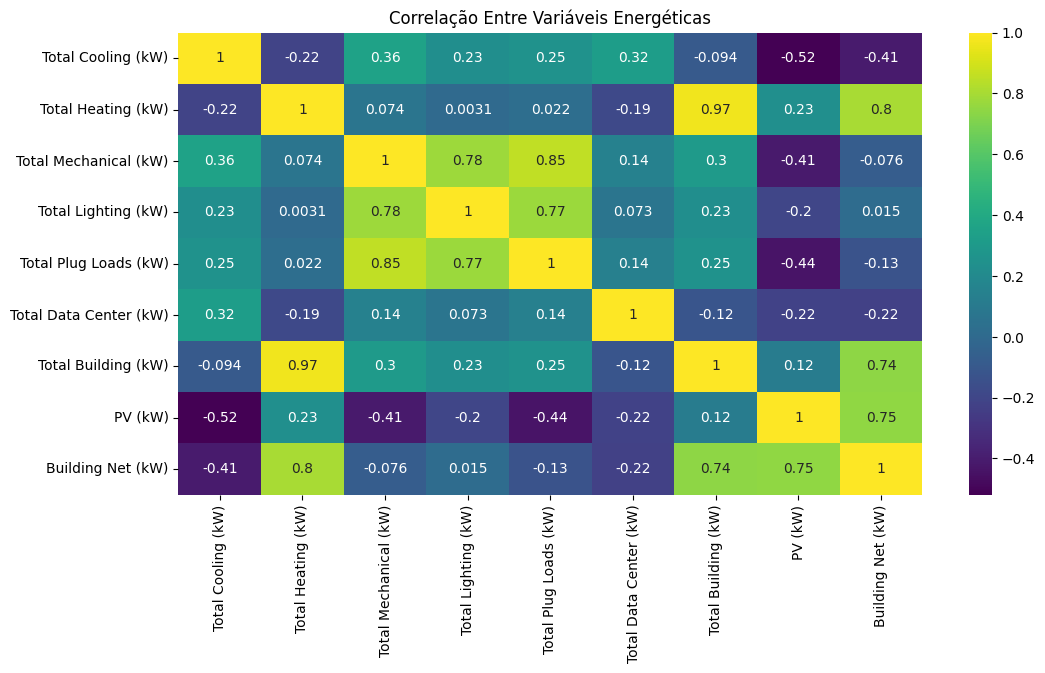

In [5]:
# Análise de correlação entre as cargas

plt.figure(figsize=(12,6))
sns.heatmap(df_clean.corr(), annot=True, cmap='viridis')
plt.title("Correlação Entre Variáveis Energéticas")
plt.show()

**Análises Importantes(heatmap):**

- Lighting, Plug Loads e Data Center têm alta correlação entre si -> consumo consistente e contínuo.

- Cooling (Resfriamento) apresenta forte correlação com o consumo total -> clima quente influencia fortemente a demanda.

- PV (Solar) possui correlação negativa com Building Net -> quanto maior a geração solar, menor o consumo líquido.


Isso significa que: A energia solar reduz diretamente o consumo líquido, mas ainda não supre integralmente a demanda.

In [7]:
# Lista de variáveis que mais afetam o consumo líquido do prédio

cor = df_clean.corr()['Building Net (kW)'].sort_values(ascending=False)
cor

,Building Net (kW)
Building Net (kW),1.000000
Total Heating (kW),0.801636
PV (kW),0.748846
Total Building (kW),0.744883
Total Lighting (kW),0.014616
Total Mechanical (kW),-0.076087
Total Plug Loads (kW),-0.127491
Total Data Center (kW),-0.224309
Total Cooling (kW),-0.411076


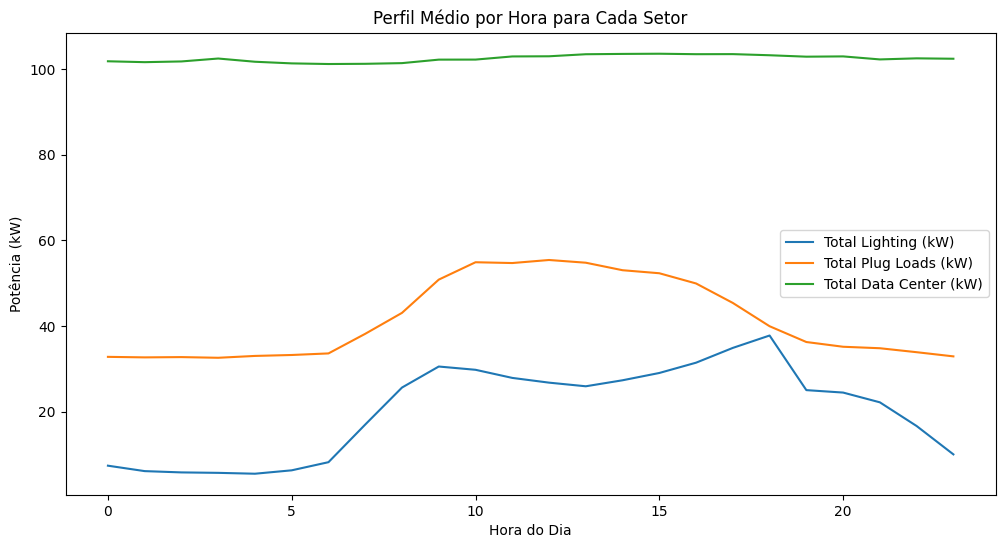

In [12]:
# Análise hora a hora - perfil de carga

df_clean['hour'] = df_clean.index.hour
hourly_profile = df_clean.groupby('hour').mean()

hourly_profile[['Total Lighting (kW)', 'Total Plug Loads (kW)', 'Total Data Center (kW)']].plot(figsize=(12,6))
plt.title("Perfil Médio por Hora para Cada Setor")
plt.xlabel("Hora do Dia")
plt.ylabel("Potência (kW)")
plt.show()

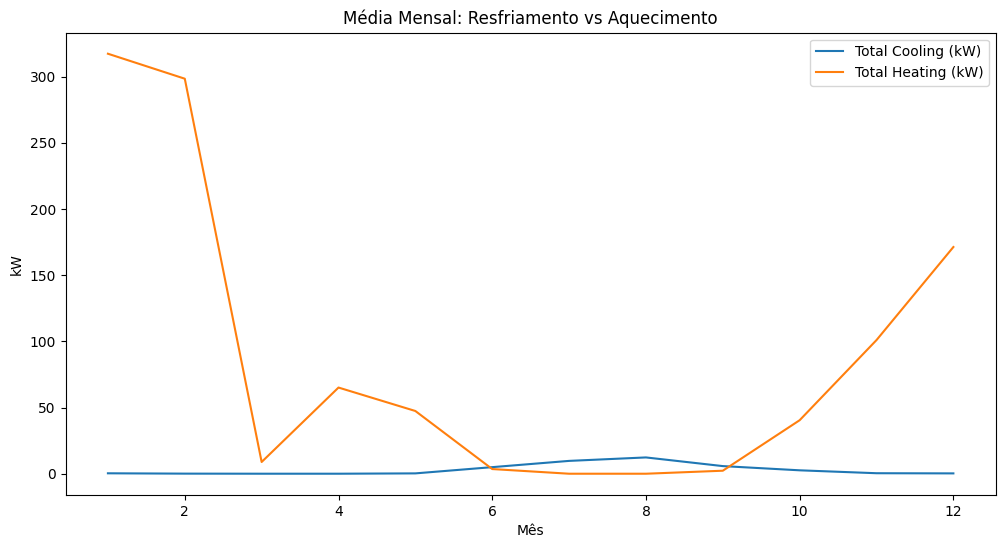

In [14]:
# Análise mensal - padrôes de estação

df_clean['month'] = df_clean.index.month
monthly = df_clean.groupby('month').mean()

monthly[['Total Cooling (kW)', 'Total Heating (kW)']].plot(figsize=(12,6))
plt.title("Média Mensal: Resfriamento vs Aquecimento")
plt.xlabel("Mês")
plt.ylabel("kW")
plt.show()


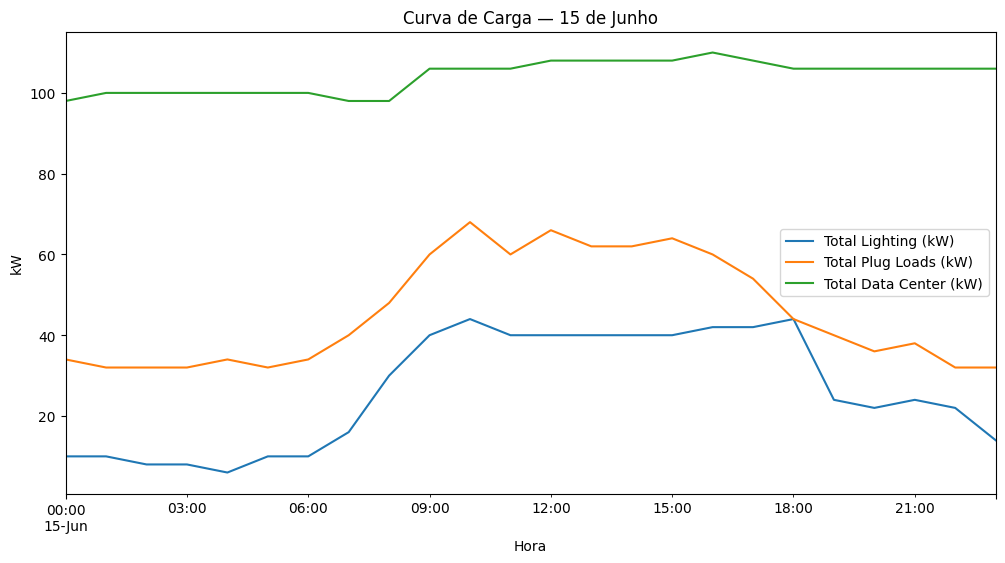

In [15]:
# Curvas de carga diária - dia típico (ex: dia 15 de julho)

dia = df_clean.loc["2011-06-15"]

dia[['Total Lighting (kW)', 'Total Plug Loads (kW)', 'Total Data Center (kW)']].plot(figsize=(12,6))
plt.title("Curva de Carga — 15 de Junho")
plt.xlabel("Hora")
plt.ylabel("kW")
plt.show()


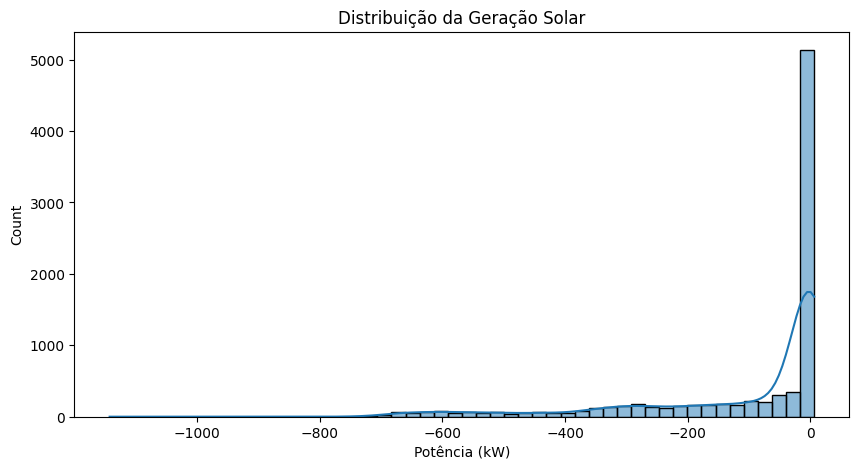

In [16]:
# Distribuição da geração solar (PV)

plt.figure(figsize=(10,5))
sns.histplot(df_clean['PV (kW)'], kde=True, bins=50)
plt.title("Distribuição da Geração Solar")
plt.xlabel("Potência (kW)")
plt.show()


In [18]:
# Capacidade de atendimento solar — % suprida pela energia solar

df['solar_ratio'] = df['PV (kW)'] / df['Total Building (kW)']

print("Média anual de cobertura solar:", df['solar_ratio'].mean())
print("Máximo registrado:", df['solar_ratio'].max())
print("Horas com 100% de suprimento:", (df['solar_ratio'] >= 1).sum())


Média anual de cobertura solar: -0.48601142584569296
Máximo registrado: 0.018633540372670808
Horas com 100% de suprimento: 0


In [19]:
# detecção de horas de pico (top 5%)

limite_pico = df['Total Building (kW)'].quantile(0.95)
picos = df[df['Total Building (kW)'] >= limite_pico]

picos.head()


,Day of Week,Total Cooling (kW),Total Heating (kW),Total Mechanical (kW),Total Lighting (kW),Total Plug Loads (kW),Total Data Center (kW),Total Building (kW),PV (kW),Building Net (kW),hour,solar_ratio
Date and Time,,,,,,,,,,,,
2011-01-01 01:00:00,Saturday,0,936,8.0,4.0,32.0,102.0,1080,0.0,1080.0,1,0.0
2011-01-01 02:00:00,Saturday,0,838,8.0,4.0,30.0,102.0,978,0.0,978.0,2,0.0
2011-01-01 03:00:00,Saturday,0,904,8.0,4.0,32.0,102.0,1046,0.0,1046.0,3,0.0
2011-01-01 04:00:00,Saturday,0,838,10.0,4.0,34.0,102.0,984,0.0,984.0,4,0.0
2011-01-01 05:00:00,Saturday,0,644,8.0,4.0,30.0,102.0,786,0.0,786.0,5,0.0


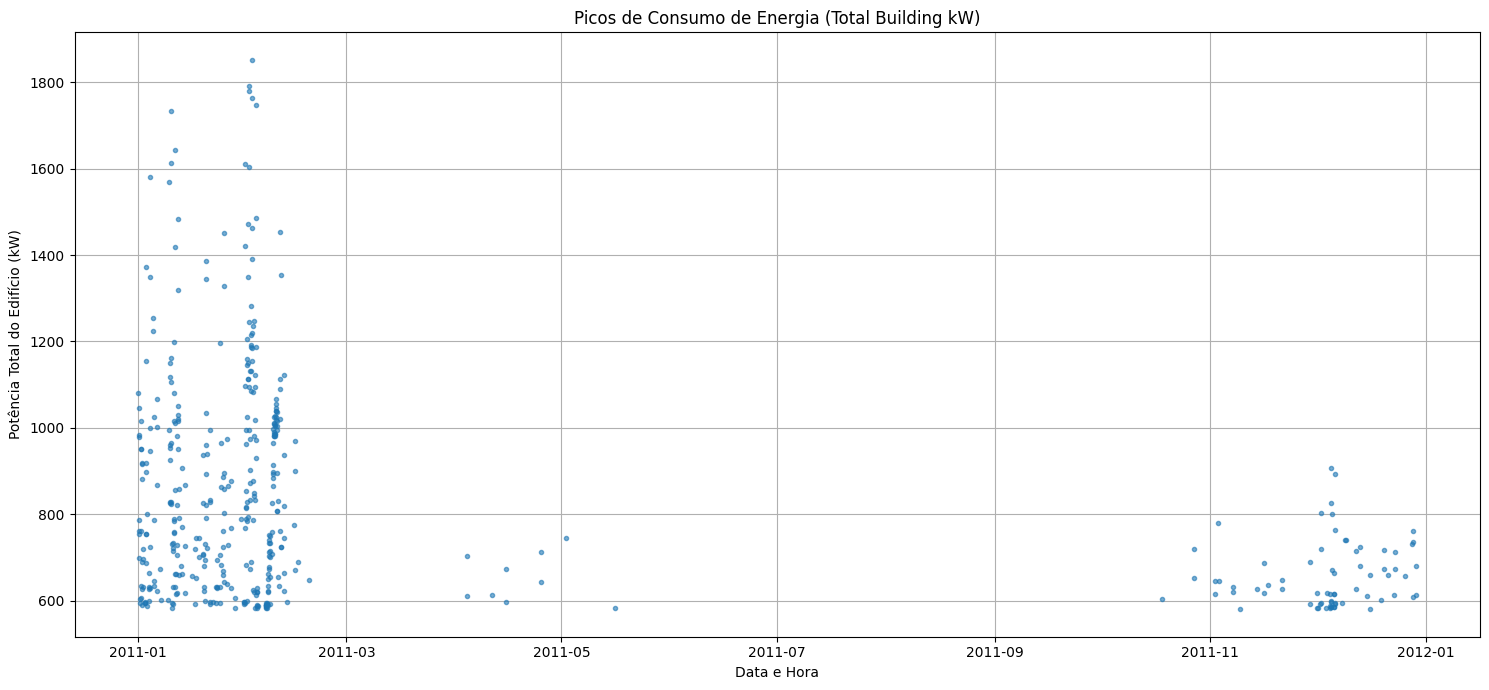

In [21]:
# Gráfico de linha para os picos de consumo ao longo do tempo
plt.figure(figsize=(15, 7))
plt.plot(picos.index, picos['Total Building (kW)'], marker='o', linestyle='', markersize=3, alpha=0.6)
plt.title('Picos de Consumo de Energia (Total Building kW)')
plt.xlabel('Data e Hora')
plt.ylabel('Potência Total do Edifício (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

Este gráfico mostra os momentos em que os picos de consumo ocorrem, permitindo identificar padrões sazonais ou horários. Cada ponto representa um período de pico.

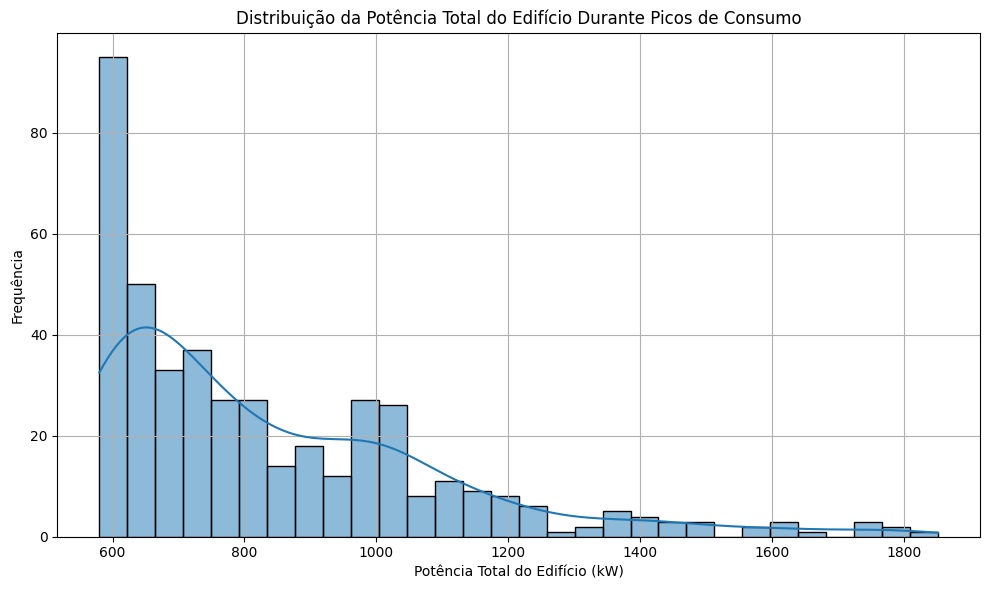

In [22]:
# Histograma da distribuição dos picos de consumo
plt.figure(figsize=(10, 6))
sns.histplot(picos['Total Building (kW)'], kde=True, bins=30)
plt.title('Distribuição da Potência Total do Edifício Durante Picos de Consumo')
plt.xlabel('Potência Total do Edifício (kW)')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

Obs: O histograma ilustra a distribuição dos valores de potência durante os períodos de pico, mostrando as faixas de consumo mais comuns quando o edifício está operando em seus níveis mais altos.

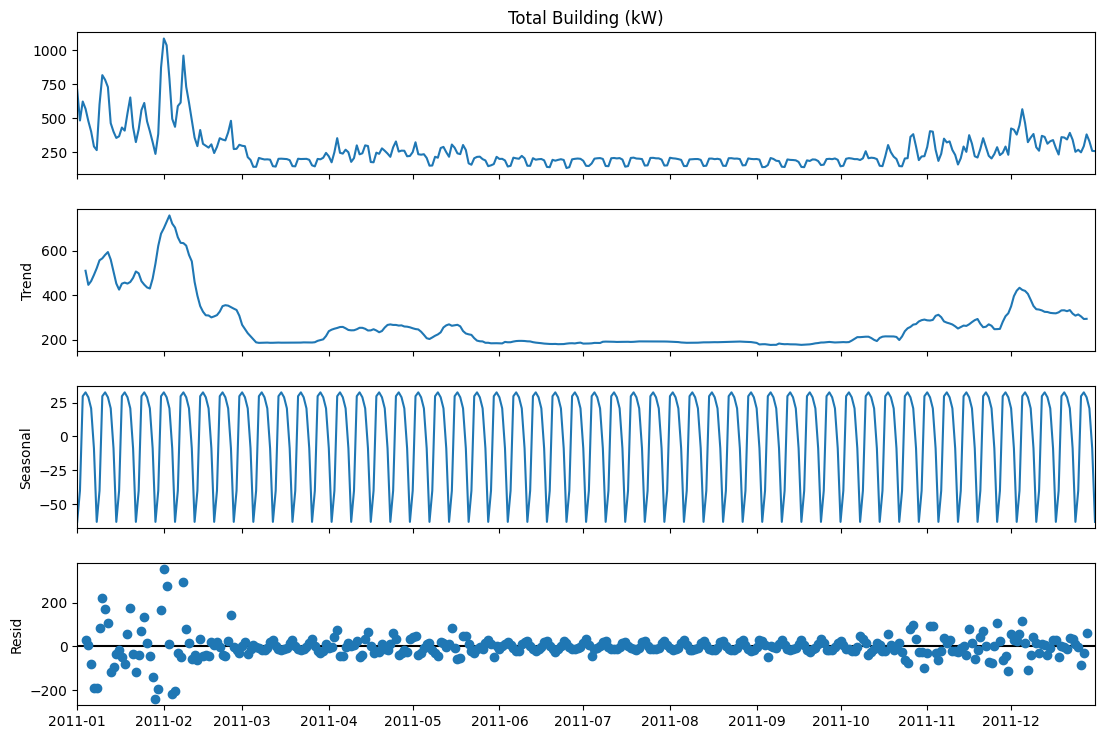

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

serie = df_clean['Total Building (kW)'].resample('D').mean()

# período para 7 para analisar a sazonalidade semanal,

decomp = seasonal_decompose(serie, model='additive', period=7)
fig = decomp.plot()
fig.set_size_inches(12,8)
plt.show()

/tmp/ipython-input-3159503642.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  serie = df['Total Building (kW)'].resample('H').mean()


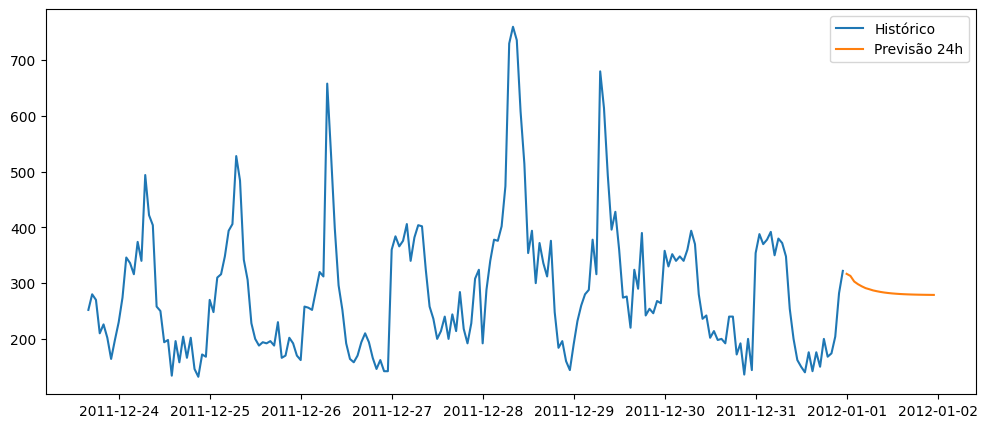

In [27]:
# Previsão básica usando ARIMA

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

serie = df['Total Building (kW)'].resample('H').mean()

model = ARIMA(serie, order=(5,1,2))
result = model.fit()

forecast = result.forecast(steps=24)

plt.figure(figsize=(12,5))
plt.plot(serie[-200:], label="Histórico")
plt.plot(forecast, label="Previsão 24h")
plt.legend()
plt.show()
